In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D, Input
from tensorflow.keras.models import Model, load_model

from tensorflow.keras.utils import to_categorical
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
from time import time
from alibi.explainers import Counterfactual

x_train shape: (60000, 28, 28) y_train shape: (60000,)


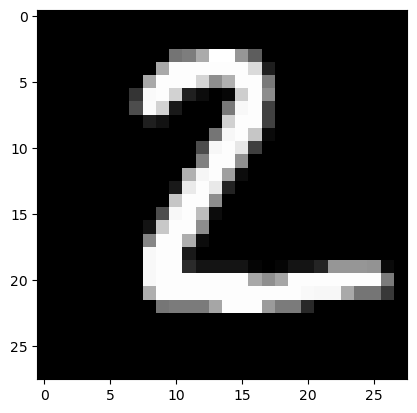

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('x_train shape:', x_train.shape, 'y_train shape:', y_train.shape)
plt.gray()
plt.imshow(x_test[1])

In [3]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255
x_train = np.reshape(x_train, x_train.shape + (1,))
x_test = np.reshape(x_test, x_test.shape + (1,))
print('x_train shape:', x_train.shape, 'x_test shape:', x_test.shape)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
print('y_train shape:', y_train.shape, 'y_test shape:', y_test.shape)

x_train shape: (60000, 28, 28, 1) x_test shape: (10000, 28, 28, 1)
y_train shape: (60000, 10) y_test shape: (10000, 10)


In [4]:
xmin, xmax = -.5, .5
x_train = ((x_train - x_train.min()) / (x_train.max() - x_train.min())) * (xmax - xmin)+ xmin
x_test = ((x_test - x_test.min()) / (x_test.max() - x_test.min())) * (xmax - xmin) + xmin

In [5]:
x_in = Input(shape=(28, 28, 1))
x = Conv2D(filters=64, kernel_size=2, padding='same', activation='relu')(x_in)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Conv2D(filters=32, kernel_size=2, padding='same', activation='relu')(x)
x = MaxPooling2D(pool_size=2)(x)
x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x_out = Dense(10, activation='softmax')(x)
cnn = Model(inputs=x_in, outputs=x_out)
cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [6]:
cnn.summary()
cnn.fit(x_train, y_train, batch_size=64, epochs=3, verbose=0)
cnn.save('mnist_cnn.h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                         

In [7]:
cnn = load_model('mnist_cnn.h5')
score = cnn.evaluate(x_test, y_test, verbose=0)
print('Test accuracy: ', score[1])

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Test accuracy:  0.9847


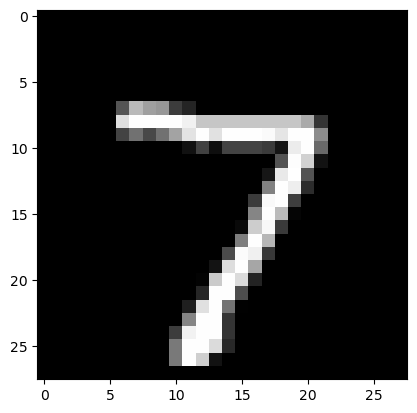

In [8]:
X = x_test[0].reshape(1,28,28,1)
plt.imshow(X.reshape(28, 28))

In [9]:
shape = (1,) + x_train.shape[1:]
target_proba = 1.0
tol = 0.01 # want counterfactuals with p(class)>0.99
target_class = 'other' # any class other than 7 will do
max_iter = 1000
lam_init = 1e-1
max_lam_steps = 10
learning_rate_init = 0.1
feature_range = (x_train.min(),x_train.max())

In [10]:
# initialize explainer
cfi = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
                     target_class=target_class, max_iter=max_iter, lam_init=lam_init,
                     max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
                     feature_range=feature_range)
start_time = time()
expls = cfi.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

`Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.


Explanation took 14.985 sec


In [11]:
print(expls.data.keys())

dict_keys(['cf', 'all', 'orig_class', 'orig_proba', 'success'])


In [12]:
print(expls.data['success'])
print(expls.data['cf'].keys())

True
dict_keys(['X', 'distance', 'lambda', 'index', 'class', 'proba', 'loss'])


In [13]:
print(expls.success)
print(expls.cf.keys())

True
dict_keys(['X', 'distance', 'lambda', 'index', 'class', 'proba', 'loss'])


Counterfactual prediction: 3 with probability 0.9904250502586365


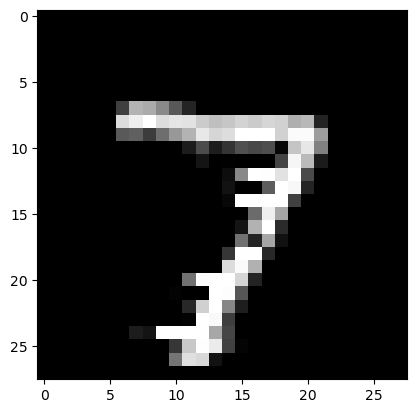

In [13]:
pred_class = expls.cf['class']
proba = expls.cf['proba'][0][pred_class]
print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(expls.cf['X'].reshape(28, 28))

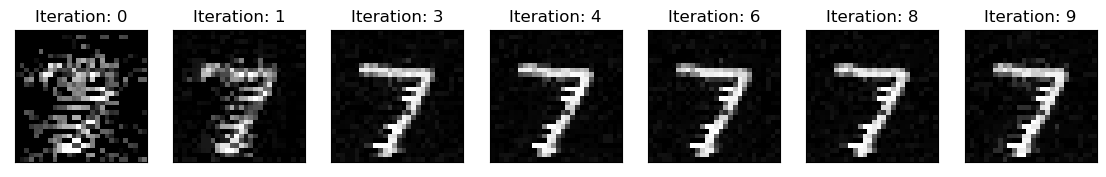

In [15]:
n_cfs = np.array([len(expls.all[iter_cf]) for iter_cf in range(max_lam_steps)])
examples = {}
for ix, n in enumerate(n_cfs):
    if n>0:
        examples[ix] = {'ix': ix, 'lambda': expls.all[ix][0]['lambda'],
        'X': expls.all[ix][0]['X']}
columns = len(examples) + 1
rows = 1
fig = plt.figure(figsize=(16,6))
for i, key in enumerate(examples.keys()):
    ax = plt.subplot(rows, columns, i+1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.imshow(examples[key]['X'].reshape(28,28))
    plt.title(f'Iteration: {key}')

In [16]:
target_class = 9
cfi = Counterfactual(cnn, shape=shape, target_proba=target_proba, tol=tol,
target_class=target_class, max_iter=max_iter, lam_init=lam_init,
max_lam_steps=max_lam_steps, learning_rate_init=learning_rate_init,
feature_range=feature_range)
explanation = start_time = time()
explanation = cfi.explain(X)
print('Explanation took {:.3f} sec'.format(time() - start_time))

Explanation took 12.267 sec


Counterfactual prediction: 9 with probability 0.9909413456916809


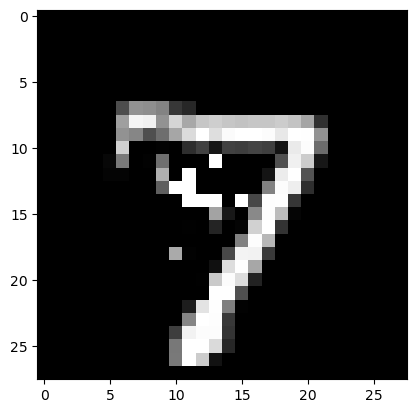

In [17]:
pred_class = explanation.cf['class']
proba = explanation.cf['proba'][0][pred_class]
print(f'Counterfactual prediction: {pred_class} with probability {proba}')
plt.imshow(explanation.cf['X'].reshape(28, 28))

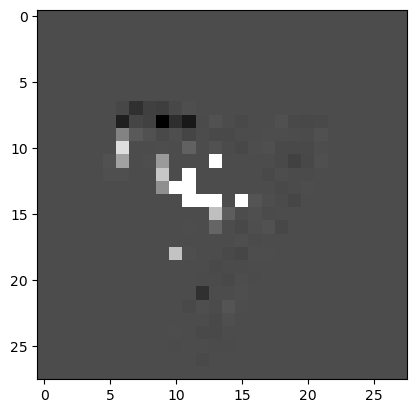

In [18]:
 plt.imshow((explanation.cf['X'] - X).reshape(28, 28))

In [19]:
os.remove('mnist_cnn.h5')